In [27]:
import numpy
print(numpy.__version__)

1.26.3


In [28]:
# ============================================================================
# STEP 1: Install Dependencies & Download Dataset
# ============================================================================
# Install specific NumPy version to match system (1.26.3)
%pip install -q kagglehub imbalanced-learn scikit-learn pandas "numpy==1.26.3" seaborn joblib

import kagglehub
import os
import numpy as np
print(f"NumPy version: {np.__version__}")

print("📥 Downloading CICIDS2018 dataset...")
dataset_path = kagglehub.dataset_download("dhoogla/csecicids2018")
print("Dataset downloaded to:", dataset_path)


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
NumPy version: 1.26.3
📥 Downloading CICIDS2018 dataset...
Dataset downloaded to: /Users/divyanshisachan/.cache/kagglehub/datasets/dhoogla/csecicids2018/versions/3


In [29]:
# ============================================================================
# STEP 2: Import Libraries & Global Config
# ============================================================================
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, shutil, json

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler

RANDOM_STATE = 42
NUMERIC_NA_FILL = 0.0
MAX_SAMPLES_PER_CLASS = 25000     # safe upper limit
WEB_ATTACK_TARGET = 2000          # safe oversample target

EXCLUDE_COLS = {
    "Flow ID","Src IP","Dst IP","Timestamp",
    "SimillarHTTP","Flow Byts/s","Flow Pkts/s"
}

print("Config loaded.")


Config loaded.


In [30]:
# ============================================================================
# STEP 3: Helper Functions
# ============================================================================

def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
    return df


def clean_columns(df):
    df = df.drop(columns=[c for c in df.columns if c in EXCLUDE_COLS], errors="ignore")
    if "label" in df.columns:
        df = df.rename(columns={"label": "Label"})
    return df


def coerce_numeric(df, label_col="Label"):
    for col in df.columns:
        if col != label_col and df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def load_parquet_files(paths):
    frames = []
    for p in paths:
        print("Loading:", os.path.basename(p))
        part = pd.read_parquet(p)
        part = clean_columns(part)
        frames.append(part)
        del part
        gc.collect()

    df = pd.concat(frames, ignore_index=True)
    df = reduce_memory(df)
    df = coerce_numeric(df)
    df = df.replace([np.inf, -np.inf], np.nan).fillna(NUMERIC_NA_FILL)
    return df


def select_features(df, label_col="Label"):
    feat_cols = [c for c in df.columns if c != label_col and pd.api.types.is_numeric_dtype(df[c])]
    return df[feat_cols], df[label_col]


In [31]:
# ============================================================================
# STEP 4: Label Grouping (7 Classes)
# ============================================================================
LABEL_MAP = {
    "Benign": "Benign",
    "Bot": "Bot",

    "FTP-BruteForce": "Bruteforce",
    "SSH-Bruteforce": "Bruteforce",
    "Brute Force -Web": "Bruteforce",
    "Brute Force -XSS": "Bruteforce",

    "DDOS attack-HOIC": "DDoS",
    "DDOS attack-LOIC-UDP": "DDoS",
    "DDoS attacks-LOIC-HTTP": "DDoS",

    "DoS attacks-GoldenEye": "DoS",
    "DoS attacks-Hulk": "DoS",
    "DoS attacks-SlowHTTPTest": "DoS",
    "DoS attacks-Slowloris": "DoS",

    "Infilteration": "Infiltration",

    "SQL Injection": "Web Attack",
}

def group_label(x): 
    return LABEL_MAP.get(x, None)


In [32]:
# ============================================================================
# STEP 5: Load Dataset & Group Labels
# ============================================================================
files = [
    "DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet",
    "DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet",
    "DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet",
    "DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet",
    "Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet"
]

paths = [os.path.join(dataset_path, f) for f in files]

raw = load_parquet_files(paths)

raw["Label"] = raw["Label"].apply(group_label)
raw = raw.dropna(subset=["Label"])

print("Labels:", raw["Label"].unique())
print("Shape:", raw.shape)


Loading: DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet
Loading: DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet
Loading: Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet
Loading: Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet
Labels: ['Benign' 'DDoS' 'Bruteforce' 'Web Attack' 'Bot' 'DoS' 'Infiltration']
Shape: (6659532, 78)


In [33]:
# ============================================================================
# STEP 6: Balanced Sampling + SAFE Web Attack Oversampling
# ============================================================================

X_all, y_all = select_features(raw)
df = X_all.copy()
df["label"] = y_all
del raw; gc.collect()

print("\n⚖️ Downsampling major classes...")
balanced = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min(len(x), MAX_SAMPLES_PER_CLASS), random_state=RANDOM_STATE))
      .reset_index(drop=True)
)

# Extract Web Attack rows after downsampling
web_df = balanced[balanced["label"] == "Web Attack"]
web_count = len(web_df)
print("Original Web Attack count:", web_count)

# -------------- SAFE OVERSAMPLING --------------
if 2 < web_count < WEB_ATTACK_TARGET:
    ros = RandomOverSampler(
        sampling_strategy={"Web Attack": WEB_ATTACK_TARGET},
        random_state=42
    )
    X_ros, y_ros = ros.fit_resample(
        balanced.drop(columns=["label"]),
        balanced["label"]
    )
    balanced = pd.concat([
        pd.DataFrame(X_ros, columns=balanced.drop(columns=["label"]).columns),
        pd.Series(y_ros, name="label")
    ], axis=1)

print("Balanced class counts:")
print(balanced["label"].value_counts())



⚖️ Downsampling major classes...
Original Web Attack count: 85
Balanced class counts:
label
Benign          25000
Bot             25000
Bruteforce      25000
DDoS            25000
DoS             25000
Infiltration    25000
Web Attack       2000
Name: count, dtype: int64


In [34]:
# ============================================================================
# STEP 7.5: Filter to Live-Extractable Features Only
# ============================================================================
import json

# Create X_bal and y_bal from balanced data
X_bal = balanced.drop(columns=["label"])
y_bal = balanced["label"]

# Load the features we can actually extract live
with open("LIVE_FEATURES.json", "r") as f:
    live_features = json.load(f)

LIVE_FEATURE_NAMES = live_features["feature_names"]
print(f"Using {len(LIVE_FEATURE_NAMES)} live-extractable features")

# Filter balanced data BEFORE train/test split
# Check which features exist in our training data
available_features = [f for f in LIVE_FEATURE_NAMES if f in X_bal.columns]
missing_features = [f for f in LIVE_FEATURE_NAMES if f not in X_bal.columns]

if missing_features:
    print(f"WARNING: {len(missing_features)} features missing from training data:")
    for f in missing_features:
        print(f"  - {f}")
    print("These will be added as zeros during live extraction.")

# Use only available features for training
X_bal = X_bal[available_features].copy()

print(f"\n✅ Filtered to {len(X_bal.columns)} live-extractable features")
print(f"Sample features: {list(X_bal.columns)[:10]}")


Using 30 live-extractable features

✅ Filtered to 30 live-extractable features
Sample features: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Fwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s']


In [35]:
# ============================================================================
# STEP 7: Train/Test Split
# ============================================================================
# X_bal and y_bal should already be set from Step 6
# If X_bal was filtered in Step 7.5, it's already ready
if 'X_bal' not in locals():
    X_bal = balanced.drop(columns=["label"])
    y_bal = balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print(f"Features: {len(X_train.columns)}")


Train size: 121600
Test size: 30400
Features: 30



Macro F1: 0.9102651309648279

Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      0.68      0.74      5000
         Bot       0.99      1.00      0.99      5000
  Bruteforce       1.00      0.99      1.00      5000
        DDoS       0.97      0.93      0.95      5000
         DoS       0.92      0.97      0.95      5000
Infiltration       0.73      0.84      0.78      5000
  Web Attack       0.94      1.00      0.97       400

    accuracy                           0.90     30400
   macro avg       0.91      0.92      0.91     30400
weighted avg       0.90      0.90      0.90     30400



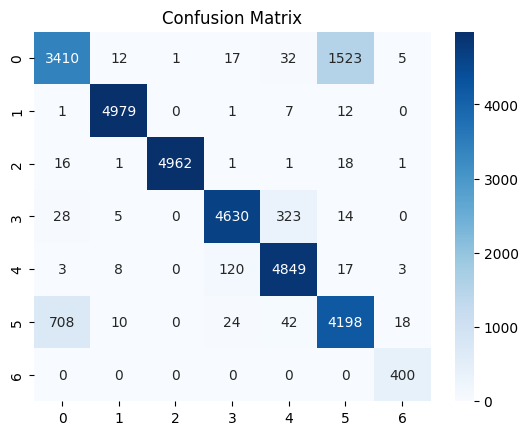

In [36]:
# ============================================================================
# STEP 8: Train Model
# ============================================================================
clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_leaf_nodes=31,
    early_stopping=True,
    random_state=None
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nMacro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [37]:
# ============================================================================
# STEP 9: Safe 5-Fold CV (Subsample)
# ============================================================================
cv_size = min(50000, len(X_train))
idx = np.random.choice(len(X_train), cv_size, replace=False)

X_cv = X_train.iloc[idx]
y_cv = y_train.iloc[idx]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X_cv, y_cv, cv=cv, scoring="f1_macro", n_jobs=1)
print("CV Scores:", scores)
print("Mean CV:", scores.mean())


CV Scores: [0.90705182 0.90373004 0.89662401 0.90290834 0.90456106]
Mean CV: 0.9029750552677502


In [38]:
# ============================================================================
# STEP 10: Save Model
# ============================================================================
from pathlib import Path
artifacts = Path("artifacts"); artifacts.mkdir(exist_ok=True)

model_path = artifacts / "ids_7class_histgb_safe.joblib"
# Save with protocol 4 for better NumPy compatibility
joblib.dump(clf, model_path, protocol=4, compress=3)

le = LabelEncoder().fit(y_bal)
joblib.dump(le, artifacts/"label_encoder.joblib", protocol=4, compress=3)

# Also save metadata for reference
metadata = {
    "model_name": "ids_7class_histgb_safe",
    "model_type": "HistGradientBoostingClassifier",
    "num_classes": len(le.classes_),
    "classes": le.classes_.tolist(),
    "num_features": len(X_train.columns),  # Now ~30, not 77
    "feature_names": X_train.columns.tolist(),  # Only live-extractable features
    "macro_f1": scores.mean() if 'scores' in locals() else None,
    "train_samples": len(X_train),
    "test_samples": len(X_test),
    "note": "Trained on live-extractable features only (30 features)"
}

import json
with open(artifacts / "model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Model saved with protocol 4.")
print(f"Model uses {len(X_train.columns)} features (live-extractable only)")


Model saved with protocol 4.
Model uses 30 features (live-extractable only)


In [39]:
# ============================================================================
# STEP 11: Inference Function
# ============================================================================
def predict_flows(df, model=clf, label_encoder=le):
    df = clean_columns(df)
    df = coerce_numeric(df)
    df = reduce_memory(df)

    X_new, _ = select_features(df)
    preds = model.predict(X_new)
    labels = label_encoder.inverse_transform(preds)

    df["predicted_label"] = labels
    return df
